# Mapping Allen institute scRNA-seq reference to Visium spatial (mouse brain)

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#read_visium)
* [Loading Allen single cell reference data](#read_allen)


* [cell2location analysis](#cell2location)
* [Loading cell2location results](#cell2location_res)
* [Evaluate mapping accuracy by comparing to Allen](#mapping_accuracy)


* [Fig 2J](#Fig2J)
* [Fig 2J supplementary spatial maps](#suppl_spatial_maps)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import scipy.sparse as ss
import h5py
import matplotlib
data_type = 'float32'

# this line should go before importing pycell2location
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
from cell2location.plt.plot_heatmap import clustermap

from matplotlib import rcParams
import seaborn as sns
import glob

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## Loading Visium data <a class="anchor" id="read_visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_data/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/zeisel/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/zeisel_negative/scvi_stereoscope/'
vis_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

In [3]:
# path for saving figures
fig_path = f'{results_folder}scvi_stereoscope/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

In [4]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [5]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# read in manual SSp cortical layer annotations
lay = pd.DataFrame()
for s in slides.keys():
    
    lay_file = vis_results_folder + 'manual_SSp_layers/SSp_ManLayerAnn_' \
                + str(s) + '.csv'
    lay_ = pd.read_csv(lay_file, index_col='Barcode')
    lay_.index = [str(s) + '_' + i for i in lay_.index]
    lay = pd.concat([lay, lay_])
    
    slides[s].obs['SSp_manual_layers'] = lay_.reindex(index=slides[s].obs_names)
    
adata.obs['SSp_manual_layers'] = lay.reindex(index=adata.obs_names) 

In [7]:
adata.obs['SSp_manual_layers'].isna().sum()

13575

... storing 'sample' as categorical
... storing 'SSp_manual_layers' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


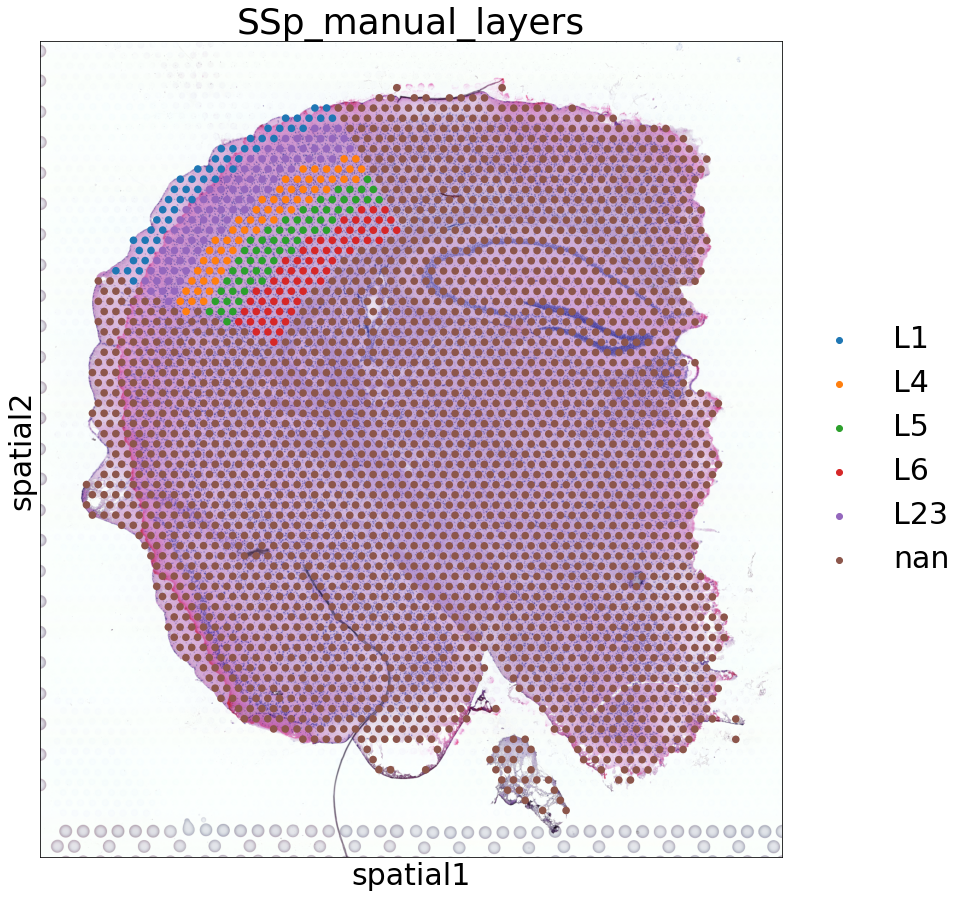

In [8]:
with matplotlib.rc_context({'axes.facecolor':  'white', 'figure.figsize': [15, 15], 'font.size': 30}):
    sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
                  color=['SSp_manual_layers'], size=1,
                  gene_symbols='SYMBOL', ncols=1,
                  save='Fig2I_layers_full.pdf')

In [9]:
adata.obs['sample'].value_counts()

ST8059049    3499
ST8059050    3497
ST8059048    2987
ST8059052    2576
ST8059051    2409
Name: sample, dtype: int64

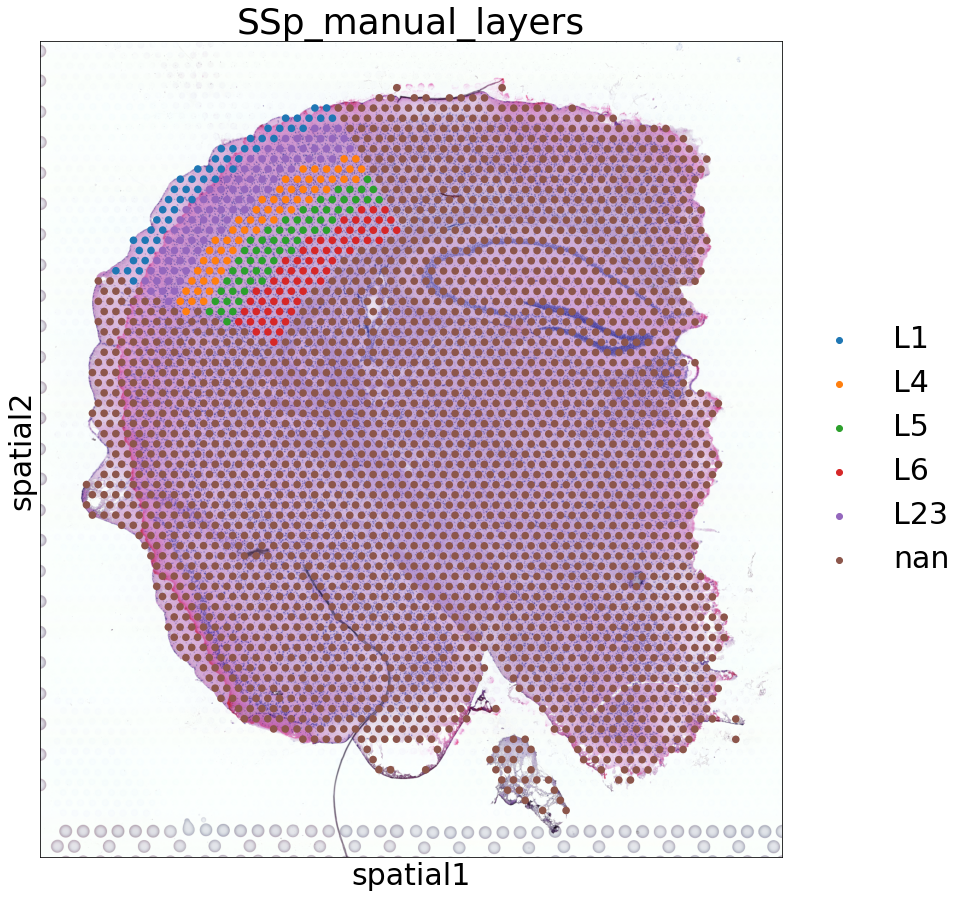

In [10]:
with matplotlib.rc_context({'axes.facecolor':  'white', 'figure.figsize': [15, 15], 'font.size': 30}):
    sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
                  color=['SSp_manual_layers'], size=1,
                  gene_symbols='SYMBOL', ncols=1,
                  save='Fig2I_layers_zoom.pdf')

Now let's look at QC: total number of counts and total number of genes per spot

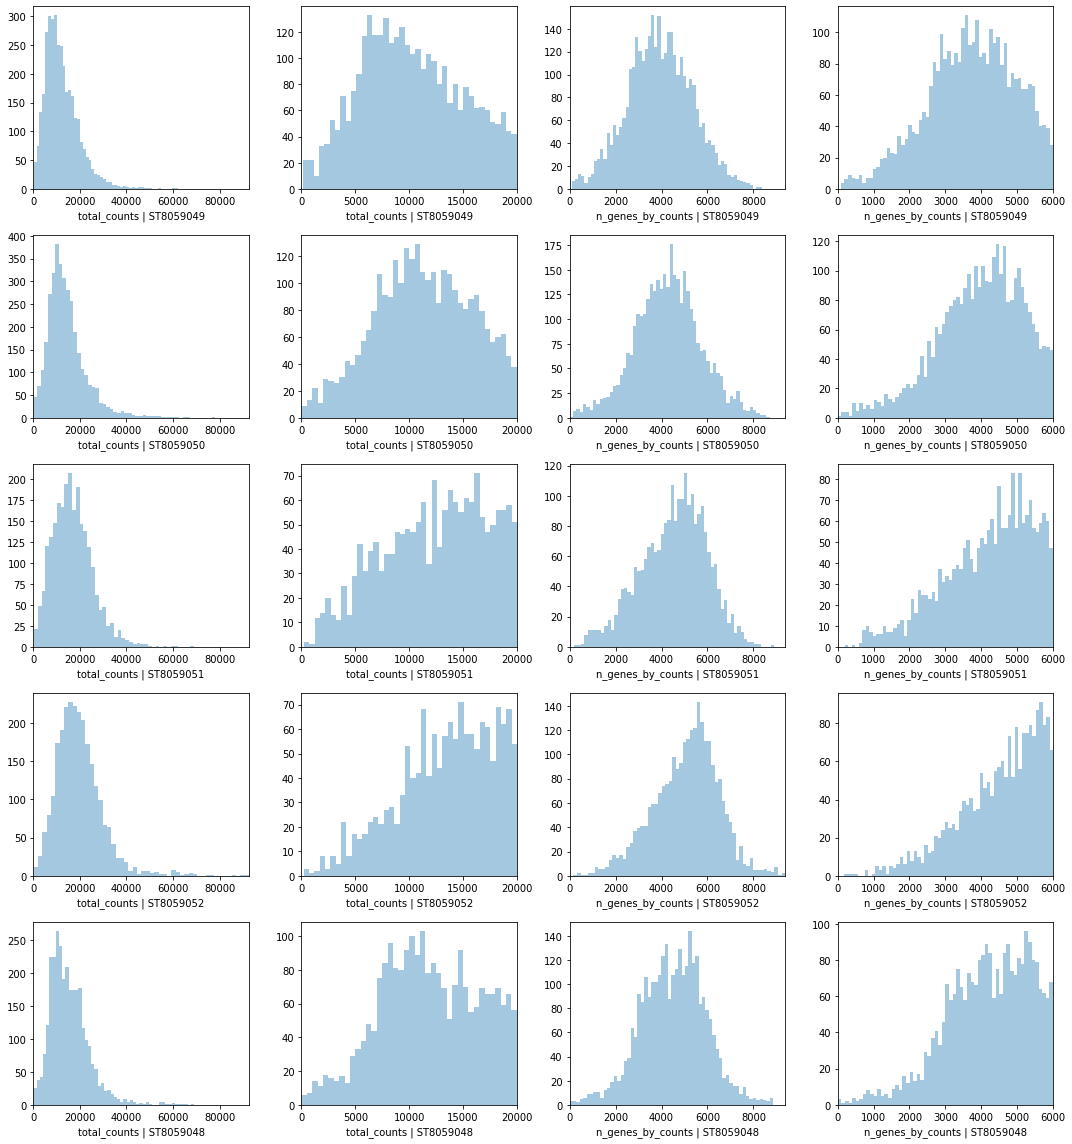

In [11]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

## Loading Allen single cell reference data <a class="anchor" id="read_allen"></a>

In [12]:
## snRNAseq reference (raw counts)
regression_model_output = 'RegressionGeneBackgroundCoverageTorch_263covariates_94986cells_12620genes'
reg_path = f'{sc_data_folder}regression_model/{regression_model_output}/'
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()

Add counts matrix as `adata.raw`

In [13]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

adata_vis = adata.copy()

In [14]:
#sc.pp.filter_genes(adata_snrna_raw, min_counts=1000)
ind = adata_vis.var_names.isin(adata_snrna_raw.var_names)
print(ind.sum())
ind = adata_vis.var_names[ind]

adata_snrna_raw = adata_snrna_raw[:, ind]
adata_snrna_raw.shape

12570


(94986, 12570)

In [15]:
adata_vis.raw = adata_vis

### Run scvi-sterescope <a class="anchor" id="scvi-sterescope"></a>

In [16]:
from scvi.data import register_tensor_from_anndata
from scvi.model.stereoscope import scStereoscope, stStereoscope
import scvi

rcParams['figure.figsize'] = 5, 5

In [18]:
adata_snrna_raw.layers["counts"] = adata_snrna_raw.X.copy()

In [19]:
scvi.data.setup_anndata(adata_snrna_raw, layer = "counts", labels_key = "Class_ClusterName")

adata_snrna_raw.obs["indices"] = np.arange(adata_snrna_raw.n_obs)
register_tensor_from_anndata(adata_snrna_raw, "ind_x", "obs", "indices")

model = scStereoscope(adata_snrna_raw)
model.train(lr = 0.01, n_epochs = 100, frequency = 1, batch_size=1024)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["Class_ClusterName"]                                    
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 94986 cells, 12570 genes, 1       
         batches, 175 labels, and 0 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 100 epochs                                                             
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, consider training for more epoch

Output()

INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  1525 s. / 100 epochs                                                


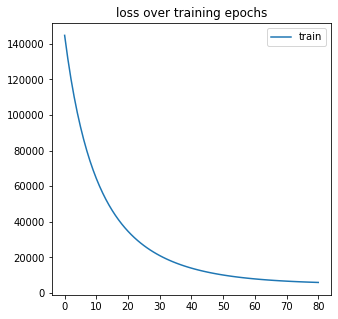

In [20]:
plt.plot(model.history["elbo_train_set"][20:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [21]:
params = model.get_params()
params[0].shape
model.save(f"{results_folder}scvi_stereoscope/scmodel_1k.pkl", overwrite = True)

- Filter genes to be the same as the scRNA-Seq data

In [22]:
adata_snrna_raw.var.index, adata.var.index

(Index(['ENSMUSG00000025902', 'ENSMUSG00000033845', 'ENSMUSG00000025903',
        'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
        'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000033740',
        'ENSMUSG00000051285',
        ...
        'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
        'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
        'ENSMUSG00000064370', 'ENSMUSG00000051412', 'ENSMUSG00000095041',
        'ENSMUSG00000063897'],
       dtype='object', length=12570),
 Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102343',
        'ENSMUSG00000025900', 'ENSMUSG00000025902', 'ENSMUSG00000104328',
        'ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000104217',
        'ENSMUSG00000033813',
        ...
        'ENSMUSG00000079192', 'ENSMUSG00000079794', 'ENSMUSG00000094799',
        'ENSMUSG00000095019', 'ENSMUSG00000094915', 'ENSMUSG00000079808',
        'ENSMUSG00000095041', 'EN

In [23]:
adata_snrna_raw.var.index.isin(adata.var.index).sum(), adata_snrna_raw.shape

(12570, (94986, 12570))

In [24]:
#intersect = np.intersect1d(adata_snrna_raw.var_names, adata.var_names)
#adata = adata[:, intersect].copy()
inter_ind = adata_snrna_raw.var.index.isin(adata.var.index)
adata = adata[:, adata_snrna_raw.var_names[inter_ind]].copy()

#mask = [x in intersect for x in adata_snrna_raw.var_names]
params = [params[0][inter_ind, :], params[1][inter_ind]]

len(adata.var_names) == params[0].shape[0]

True

In [25]:
adata.layers["counts"] = adata.X.copy()
scvi.data.setup_anndata(adata, layer = "counts")

adata.obs["indices"] = np.arange(adata.n_obs)
register_tensor_from_anndata(adata, "ind_x", "obs", "indices")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14968 cells, 12570 genes, 1       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [26]:
spatial_model = stStereoscope(adata, params)
spatial_model.train(lr = 0.01, n_epochs = 20000, train_size = 1, frequency = 1, batch_size=1393)

INFO     Training for 20000 epochs                                                           
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  51961 s. / 20000 epochs                                             


In [27]:
help(spatial_model.train)

Help on method train in module scvi.model.stereoscope:

train(n_epochs: Union[int, NoneType] = None, train_size: float = 0.9, test_size: Union[float, NoneType] = None, lr: float = 0.001, frequency: Union[int, NoneType] = None, train_fun_kwargs: dict = {}, **kwargs) method of scvi.model.stereoscope.stStereoscope instance



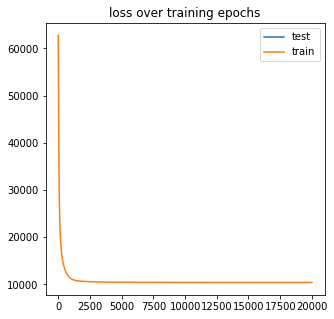

In [28]:
plt.plot(spatial_model.history["elbo_test_set"][0:], label = "test")
plt.plot(spatial_model.history["elbo_train_set"][0:], label = "train")
plt.title("loss over training epochs")
plt.legend()

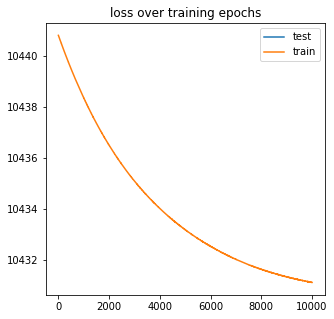

In [29]:
plt.plot(spatial_model.history["elbo_test_set"][10000:], label = "test")
plt.plot(spatial_model.history["elbo_train_set"][10000:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [30]:
adata_snrna_raw.var_names, adata.var_names

(Index(['ENSMUSG00000025902', 'ENSMUSG00000033845', 'ENSMUSG00000025903',
        'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
        'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000033740',
        'ENSMUSG00000051285',
        ...
        'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
        'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
        'ENSMUSG00000064370', 'ENSMUSG00000051412', 'ENSMUSG00000095041',
        'ENSMUSG00000063897'],
       dtype='object', length=12570),
 Index(['ENSMUSG00000025902', 'ENSMUSG00000033845', 'ENSMUSG00000025903',
        'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
        'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000033740',
        'ENSMUSG00000051285',
        ...
        'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
        'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
        'ENSMUSG00000064370', 'EN

In [31]:
import pandas as pd
adata.obsm["decomposition"] = pd.DataFrame(data = spatial_model.get_proportions(), index = adata.obs.index, 
                                           columns = adata_snrna_raw.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"])


In [32]:
for ct in adata.obsm["decomposition"].columns:
    adata.obs[ct] = adata.obsm["decomposition"][ct]

In [33]:
adata.write(f"{results_folder}scvi_stereoscope/sp_20k.h5ad")

... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'SSp_manual_layers' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


In [34]:
adata_vis = adata.copy()

sample_type = 'stereoscope'
adata_vis.obsm["stereoscope"] = adata_vis.obsm["decomposition"].values

adata_vis.obsm["decomposition"].columns = [f'scVI_stereoscope{i}' for i in adata_vis.obsm["decomposition"].columns]
adata_vis.obs[adata_vis.obsm["decomposition"].columns] = adata_vis.obsm["decomposition"]

Modules and their versions used for this analysis

In [37]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.4
numpy.core 1.19.4
numpy.core._multiarray_umath 3.1
numpy.lib 1.19.4
numpy.linalg._umath_linalg b'0.1.5'
scipy 1.5.3
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
anndata 0.7.4
h5py 2.10.0
n